## Preprocessing

In [1]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim import downloader

# Download required NLTK data and Gensim Word2Vec model
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
word2vec_wiki = downloader.load('glove-wiki-gigaword-100')

[nltk_data] Downloading package punkt to /Users/jaewoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaewoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jaewoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jaewoo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Function to map NLTK's part-of-speech tags to those accepted by the WordNet lemmatizer
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocessing function for Word2Vec
def preprocess_text(text):
    # Tokenize, lowercase
    tokens = word_tokenize(text.lower())
    # Remove Stopwords
    tokens = [token for token in tokens if token not in stopwords.words('english')]

    # Lemmatization uisng Part-of-Speech (POS) tags
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

    return tokens

def rf_preprocessed_text(text):
    processed_text_list = preprocess_text(text)
    return ' '.join(processed_text_list)


In [3]:
# Train dataset
data_df = pd.read_csv('data.csv')
train_df = pd.read_csv('train.csv')
validation_df = pd.read_csv('dev.csv')
test_df = pd.read_csv('test.csv')

## Modeling

### Random Forest

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import make_pipeline

# Sample text data and labels
X_train, y_train = train_df['text'].apply(rf_preprocessed_text), train_df['label']
X_val, y_val = validation_df['text'].apply(rf_preprocessed_text), validation_df['label']
X_test, y_test = test_df['text'].apply(rf_preprocessed_text), test_df['label']

# Step 1 & 2: Preprocess the text and convert to TF-IDF features
BoWvectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = BoWvectorizer.fit_transform(X_train)

print("Starting Random Forest Training...")
# Step 3: Train the Random Forest classifier with hyperparameter tuning
rf_best_score = 0
rf_best_model = None
for n_estimators in [100, 300, 500]:
    for max_depth in [100, 200, 300]:
        random_forest_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features='sqrt')
        random_forest_clf.fit(X_train_tfidf, y_train)
        
        # Use validation set to select the best model
        val_predictions = random_forest_clf.predict(BoWvectorizer.transform(X_val))
        rf_score = metrics.f1_score(y_val, val_predictions)
        print("F1 Score of # Estimators: ", n_estimators, ", Max Depth: ", max_depth, "F1 Score: ", rf_score)
        if rf_score > rf_best_score:
            rf_best_score = rf_score
            rf_best_model = random_forest_clf

print(f"Best F1 Score on Validation Set: {rf_best_score}")

Starting Random Forest Training...
F1 Score of # Estimators:  100 , Max Depth:  100 F1 Score:  0.8918918918918919
F1 Score of # Estimators:  100 , Max Depth:  200 F1 Score:  0.8839285714285714
F1 Score of # Estimators:  100 , Max Depth:  300 F1 Score:  0.8778280542986425
F1 Score of # Estimators:  300 , Max Depth:  100 F1 Score:  0.8918918918918919
F1 Score of # Estimators:  300 , Max Depth:  200 F1 Score:  0.8959276018099548
F1 Score of # Estimators:  300 , Max Depth:  300 F1 Score:  0.8918918918918919
F1 Score of # Estimators:  500 , Max Depth:  100 F1 Score:  0.8928571428571429
F1 Score of # Estimators:  500 , Max Depth:  200 F1 Score:  0.8878923766816144
F1 Score of # Estimators:  500 , Max Depth:  300 F1 Score:  0.8888888888888888
Best F1 Score on Validation Set: 0.8959276018099548


### Attention-Based Neural Network

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

import torch
import torch.nn as nn
from torch import optim
from tqdm.auto import tqdm, trange

# import wandb

from attention_based_NN import AttentionNNClassifier

# import wandb

/Users/jaewoo/miniforge3/envs/torch-3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def convert_text_to_ids(text):
    tokenized_text = preprocess_text(text)
    return [word2vec_wiki.key_to_index[word] for word in tokenized_text if word in word2vec_wiki]

In [7]:
def create_data_loader(df, batch_size):
    list = np.array(df.apply(lambda x: (np.array(convert_text_to_ids(x['text'])), np.array(x['label'], dtype="float32")), axis=1))
    return DataLoader(list, batch_size=batch_size, shuffle=False)

In [32]:
# Hyperparameters
batch_size = 1 # FIXED
learning_rate = 9e-3  # η
num_heads = 8 # Number of heads
epochs = 10  # Number of epochs

In [9]:
# create data loaders
train_data_loader = create_data_loader(train_df, batch_size)
val_data_loader = create_data_loader(validation_df, batch_size)
test_data_loader = create_data_loader(test_df, batch_size)

In [10]:
# Configure Device
device = 'cpu' 
if torch.backends.mps.is_available():
    device = 'mps'
if torch.cuda.is_available():
    device = 'cuda'
print(f"Using '{device}' device")

Using 'mps' device


In [31]:
from sklearn import metrics
def run_eval(model, eval_data):
    '''
    Scores the model on the evaluation data and returns the F1
    '''
    with torch.no_grad():
        eval_text = [row[0].to(device) for row in eval_data]
        eval_label = [row[1] for row in eval_data]
        predictions = [model(text)[0].to("cpu") >= 0.5 for text in eval_text]

        return metrics.f1_score(eval_label, predictions)

In [ ]:
# TODO: Set your training stuff, hyperparameters, models, etc. here
ANN_model = AttentionNNClassifier(word2vec_wiki, num_heads, device).to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(ANN_model.parameters(), lr=learning_rate)

# TODO: initialize weights and biases (wandb) here
# wandb.init(project="attention-training")
# wandb.watch(model)

# HINT: wrapping the epoch/step loops in nested tqdm calls is a great way
# to keep track of how fast things are and how much longer training will take
ANN_model.train()

highest_f1_score = 0
for epoch in range(epochs):
    loss_sum = 0
    loop = tqdm(train_data_loader, leave=True)
    # TODO: use your DataLoader to iterate over the data
    for step, data in enumerate(loop):

        # NOTE: since you created the data np.array instances,
        # these have now been converted to Tensor objects for us
        word_ids, label = data
        word_ids, label = word_ids.to(device), label.to(device)

        # TODO: Fill in all the training details here
        prediction = ANN_model(word_ids)[0]
        loss = criterion(prediction, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # TODO: Based on the details in the Homework PDF, periodically
        # report the running-sum of the loss to weights and biases. Be sure
        # to reset the running sum after reporting it.
        # loss_sum += loss.item()
        # if (step + 1) % 100 == 0:  # Log every 100 steps, adjust based on your preference
        #     print("Step: ", step+1, "Cum Loss: ", loss_sum)
        # #     wandb.log({"cumulative_loss": loss_sum})
        # #     # writer.add_scalar("Loss/train", loss_sum, epoch)
        #     loss_sum = 0.0  # Reset loss sum after logging

        # loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        # loop.set_postfix(loss=loss.item())

        # Optional TODO: periodically evaluate the model on the dev set and
        # report it to weights and biases
        if (step + 1) % 300 == 0:
            f1_score_dev = run_eval(ANN_model, val_data_loader)
            print("f1_score_dev: ", f1_score_dev)
            if f1_score_dev > highest_f1_score:
                highest_f1_score = f1_score_dev
                # save the best model seen
                torch.save(ANN_model.state_dict(), 'ANN_model.pth')

print("Highest F1-Score: ", highest_f1_score)
                
ANN_model.load_state_dict(torch.load('ANN_model.pth'))
# once you finish training, it's good practice to switch to eval.
# wandb.finish()
ANN_model.eval()

### DistllBERT Transformer Model

In [13]:
# Trained from BERT_train.py file
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
DistillBERTmodel = DistilBertForSequenceClassification.from_pretrained('DistillBERT')
DistillBERTtokenizer = DistilBertTokenizer.from_pretrained('DistillBERTTokenizer')
DistillBERTmodel.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

### RoBERTa Transformer Model

In [14]:
# Trained from BERT_train.py file
from transformers import RobertaForSequenceClassification, RobertaTokenizer
RoBERTamodel = RobertaForSequenceClassification.from_pretrained('RoBERTa')
RoBERTatokenizer = RobertaTokenizer.from_pretrained('RoBERTaTokenizer')
RoBERTamodel.eval()


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

## Evaluation

In [15]:
import random
import matplotlib.pyplot as plt
from sklearn import metrics
random.seed(595)

In [16]:
test_df = pd.read_csv('test.csv')
test_df['text'] = test_df['text'].astype(str)
test_labels = test_df['label'].to_list()
test_text = [row[0].unsqueeze(0).to(device) for row in test_data_loader]

In [17]:
# Benchmark 1: Random
random_preds = [random.randint(0, 1) for _ in range(len(test_labels))]

# Benchamrk 2: All 1s
all_one_preds = [1] * len(test_labels)

In [18]:
X_test_tfidf = BoWvectorizer.transform(X_test)
random_forest_preds = rf_best_model.predict(X_test_tfidf)

In [34]:
# Attention-based Neural Network
ANN_preds = [int(ANN_model(data[0])[0].to("cpu")[0] >= 0.5) for data in test_text]

In [20]:
# Tokenize the text
def DistilBERT_tokenize_texts(text_list):
    return DistillBERTtokenizer(text_list, padding=True, truncation=True, return_tensors="pt", max_length=512)

def DistillBERT_predict_labels(inputs):
    batch_size = 32  # Adjust batch size according to your system's capabilities
    predictions = []
    for i in range(0, len(inputs['input_ids']), batch_size):
        batch_inputs = {key: val[i:i+batch_size] for key, val in inputs.items()}
        with torch.no_grad():
            outputs = DistillBERTmodel(**batch_inputs)
        preds = outputs.logits.argmax(dim=-1)
        predictions.extend(preds.tolist())
    return predictions

DistillBERT_inputs = DistilBERT_tokenize_texts(test_df['text'].tolist())
DistillBERT_preds = DistillBERT_predict_labels(DistillBERT_inputs)

In [21]:
# Tokenize the text
def RoBERTa_tokenize_texts(text_list):
    return RoBERTatokenizer(text_list, padding=True, truncation=True, return_tensors="pt", max_length=512)

def RoBERTa_predict_labels(inputs):
    batch_size = 32  # Adjust batch size according to your system's capabilities
    predictions = []
    for i in range(0, len(inputs['input_ids']), batch_size):
        batch_inputs = {key: val[i:i+batch_size] for key, val in inputs.items()}
        with torch.no_grad():
            outputs = RoBERTamodel(**batch_inputs)
        preds = outputs.logits.argmax(dim=-1)
        predictions.extend(preds.tolist())
    return predictions

test_df['text'] = test_df['text'].astype(str)
RoBERTa_inputs = RoBERTa_tokenize_texts(test_df['text'].tolist())
RoBERTa_preds = RoBERTa_predict_labels(RoBERTa_inputs)

In [35]:
# F1-Score
benchmark_1_f1_score = metrics.f1_score(test_labels, random_preds)
benchmark_2_f1_score = metrics.f1_score(test_labels, all_one_preds)
random_forest_f1_score = metrics.f1_score(y_test, random_forest_preds)
ANN_f1_score = metrics.f1_score(y_test, ANN_preds)
DistillBERT_f1_score = metrics.f1_score(y_test, DistillBERT_preds)
RoBERTa_f1_score = metrics.f1_score(y_test, RoBERTa_preds)

# Accuracy
benchmark_1_accuracy = metrics.accuracy_score(test_labels, random_preds)
benchmark_2_accuracy = metrics.accuracy_score(test_labels, all_one_preds)
random_forest_accuracy = metrics.accuracy_score(test_labels, random_forest_preds)
ANN_accuracy = metrics.accuracy_score(test_labels, ANN_preds)
DistillBERT_accuracy = metrics.accuracy_score(test_labels, DistillBERT_preds)
RoBERTa_accuracy = metrics.accuracy_score(test_labels, RoBERTa_preds)

# # Cohen's Kappa
# benchmark_1_cohen = metrics.cohen_kappa_score(test_labels, random_preds)
# benchmark_2_cohen = metrics.cohen_kappa_score(test_labels, all_one_preds)
# random_forest_cohen = metrics.cohen_kappa_score(test_labels, random_forest_preds)

print("Benchmark 1 (Random): F1 Score - ", benchmark_1_f1_score, ", Accuracy - ", benchmark_1_accuracy)
print("Benchmark 2 (All 1s): F1 Score - ", benchmark_2_f1_score, ", Accuracy - ", benchmark_2_accuracy)
print("Random Forest: F1 Score - ", random_forest_f1_score, ", Accuracy - ", random_forest_accuracy)
print("Attention Neural Network: F1 Score - ", ANN_f1_score, ", Accuracy - ", ANN_accuracy)
print("DistillBERT: F1 Score - ", DistillBERT_f1_score, ", Accuracy - ", DistillBERT_accuracy)
print("RoBERTa: F1 Score - ", RoBERTa_f1_score, ", Accuracy - ", RoBERTa_accuracy)


# Confusion matrices
benchmark_1_CM = metrics.confusion_matrix(test_labels, random_preds)
benchmark_2_CM = metrics.confusion_matrix(test_labels, all_one_preds)
random_forest_CM = metrics.confusion_matrix(test_labels, random_forest_preds)
ANN_CM = metrics.confusion_matrix(test_labels, ANN_preds)
DistillBERT_CM = metrics.confusion_matrix(test_labels, DistillBERT_preds)
RoBERTa_CM = metrics.confusion_matrix(test_labels, RoBERTa_preds)

benchmark_1_CM_img = metrics.ConfusionMatrixDisplay(benchmark_1_CM)
benchmark_2_CM_img = metrics.ConfusionMatrixDisplay(benchmark_2_CM)
random_forest_CM_img = metrics.ConfusionMatrixDisplay(random_forest_CM)
ANN_CM_img = metrics.ConfusionMatrixDisplay(ANN_CM)
DistillBERT_CM_img = metrics.ConfusionMatrixDisplay(DistillBERT_CM)
RoBERTa_CM_img = metrics.ConfusionMatrixDisplay(RoBERTa_CM)

Benchmark 1 (Random): F1 Score -  0.5614035087719298 , Accuracy -  0.5
Benchmark 2 (All 1s): F1 Score -  0.7447698744769874 , Accuracy -  0.5933333333333334
Random Forest: F1 Score -  0.8110599078341014 , Accuracy -  0.7266666666666667
Attention Neural Network: F1 Score -  0.8205128205128205 , Accuracy -  0.7666666666666667
DistillBERT: F1 Score -  0.9175257731958762 , Accuracy -  0.8933333333333333
RoBERTa: F1 Score -  0.9555555555555556 , Accuracy -  0.9466666666666667


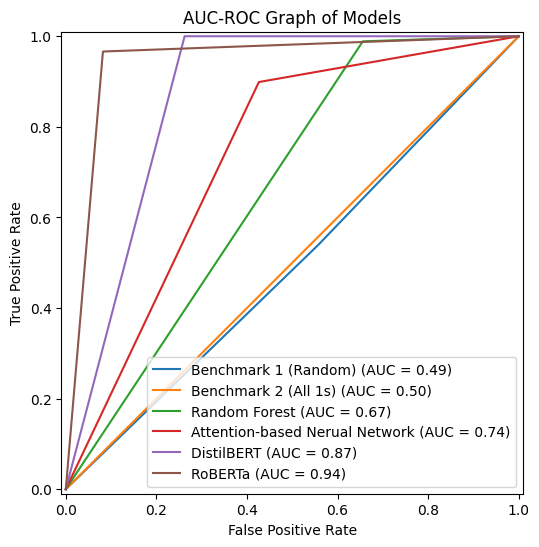

In [47]:
# AUC_ROC
benchmark_1_roc_auc = metrics.roc_auc_score(test_labels, random_preds)
benchmark_2_roc_auc = metrics.roc_auc_score(test_labels, all_one_preds)
random_forest_roc_auc = metrics.roc_auc_score(test_labels, random_forest_preds)
ANN_roc_auc = metrics.roc_auc_score(test_labels, ANN_preds)
DistillBERT_roc_auc = metrics.roc_auc_score(test_labels, DistillBERT_preds)
RoBERTa_roc_auc = metrics.roc_auc_score(test_labels, RoBERTa_preds)

fpr1, tpr1, _ = metrics.roc_curve(test_labels, random_preds)
fpr2, tpr2, _ = metrics.roc_curve(test_labels, all_one_preds)
fpr_rf, tpr_rf, _ = metrics.roc_curve(test_labels, random_forest_preds)
fpr_ANN, tpr_ANN, _ = metrics.roc_curve(test_labels, ANN_preds)
fpr_DistillBERT, tpr_DistillBERT, _ = metrics.roc_curve(test_labels, DistillBERT_preds)
fpr_RoBERTa, tpr_RoBERTa, _ = metrics.roc_curve(test_labels, RoBERTa_preds)

roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)
roc_auc_rf = metrics.auc(fpr_rf, tpr_rf)
roc_auc_ANN = metrics.auc(fpr_ANN, tpr_ANN)
roc_auc_DistillBERT = metrics.auc(fpr_DistillBERT, tpr_DistillBERT)
roc_auc_RoBERTa = metrics.auc(fpr_RoBERTa, tpr_RoBERTa)


plt.figure(figsize=(6, 6))
ax = plt.gca()
display1 = metrics.RocCurveDisplay(fpr=fpr1, tpr=tpr1, roc_auc=roc_auc1, estimator_name="Benchmark 1 (Random)").plot(ax=ax)
display2 = metrics.RocCurveDisplay(fpr=fpr2, tpr=tpr2, roc_auc=roc_auc2, estimator_name="Benchmark 2 (All 1s)").plot(ax=ax)
display_rf = metrics.RocCurveDisplay(fpr=fpr_rf, tpr=tpr_rf, roc_auc=roc_auc_rf, estimator_name="Random Forest").plot(ax=ax)
display_ANN = metrics.RocCurveDisplay(fpr=fpr_ANN, tpr=tpr_ANN, roc_auc=roc_auc_ANN, estimator_name="Attention-based Nerual Network").plot(ax=ax)
display_DistillBERT = metrics.RocCurveDisplay(fpr=fpr_DistillBERT, tpr=tpr_DistillBERT, roc_auc=roc_auc_DistillBERT, estimator_name="DistilBERT").plot(ax=ax)
display_RoBERTa = metrics.RocCurveDisplay(fpr=fpr_RoBERTa, tpr=tpr_RoBERTa, roc_auc=roc_auc_RoBERTa, estimator_name="RoBERTa").plot(ax=ax)
plt.title("AUC-ROC Graph of Models")
plt.show()

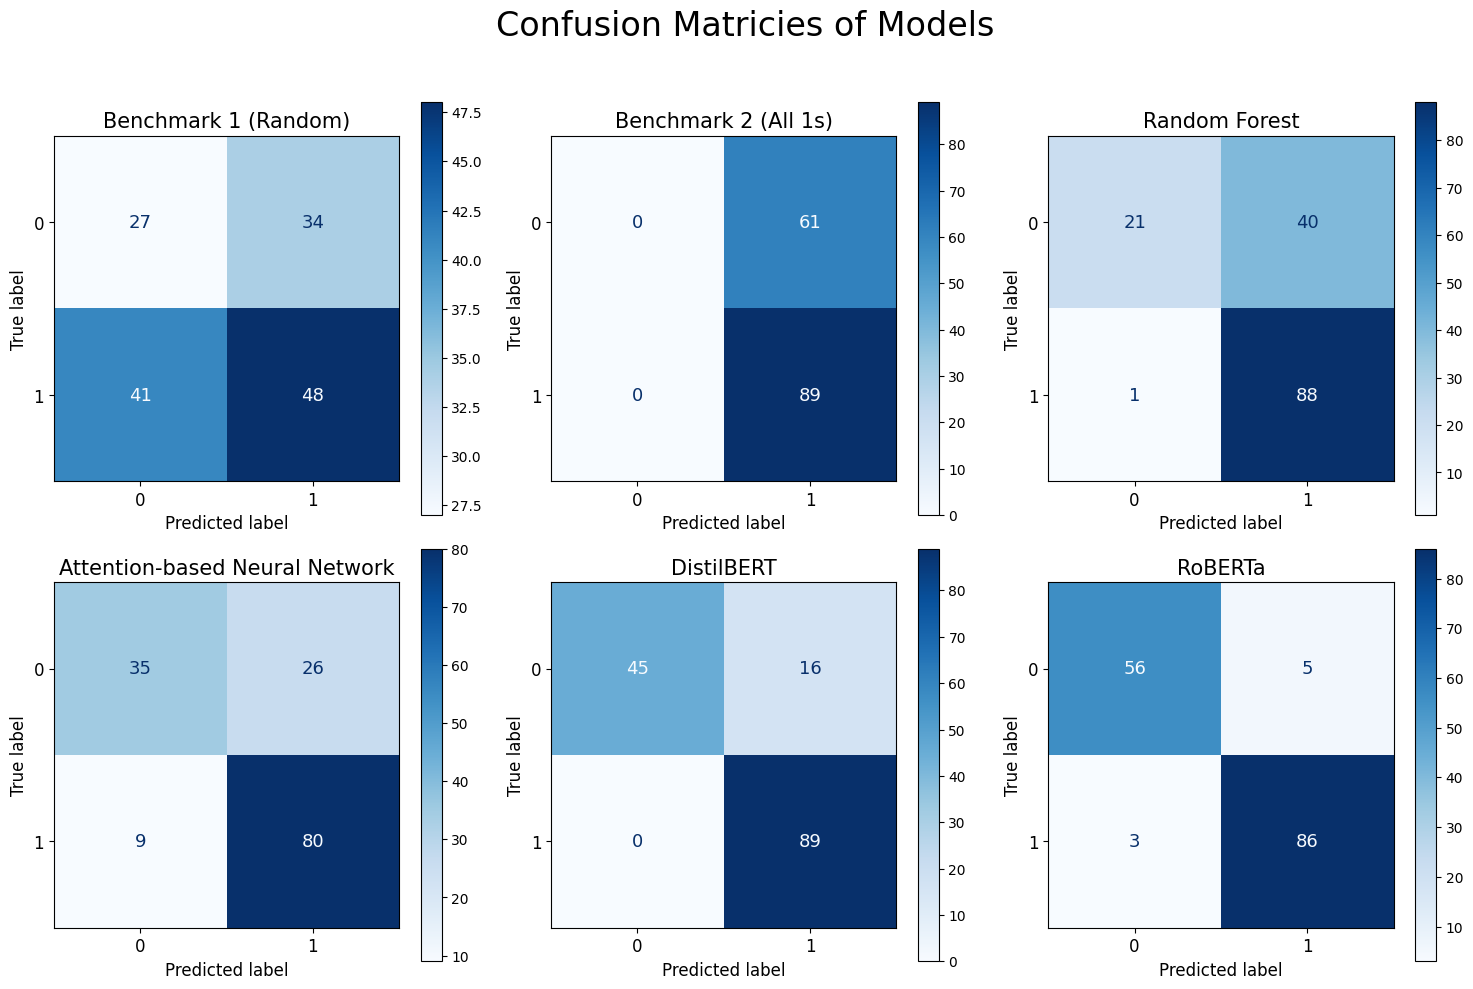

In [49]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
benchmark_1_CM_img.plot(ax=ax[0][0], cmap="Blues", text_kw={'fontsize': 13})
benchmark_2_CM_img.plot(ax=ax[0][1], cmap="Blues", text_kw={'fontsize': 13})
random_forest_CM_img.plot(ax=ax[0][2], cmap="Blues", text_kw={'fontsize': 13})
ANN_CM_img.plot(ax=ax[1][0], cmap="Blues", text_kw={'fontsize': 13})
DistillBERT_CM_img.plot(ax=ax[1][1], cmap="Blues", text_kw={'fontsize': 13})
RoBERTa_CM_img.plot(ax=ax[1][2], cmap="Blues", text_kw={'fontsize': 13})

ax[0][0].set_title('Benchmark 1 (Random)', fontsize=15)
ax[0][1].set_title('Benchmark 2 (All 1s)', fontsize=15)
ax[0][2].set_title('Random Forest', fontsize=15)
ax[1][0].set_title('Attention-based Neural Network', fontsize=15)
ax[1][1].set_title('DistilBERT', fontsize=15)
ax[1][2].set_title('RoBERTa', fontsize=15)

for axis in ax.flat:
    axis.set_xlabel('Predicted label', fontsize=12)
    axis.set_ylabel('True label', fontsize=12)
    axis.tick_params(axis='both', which='major', labelsize=12)

fig.suptitle("Confusion Matricies of Models", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Attention Based Nerual Network - Attention Analysis

In [25]:
def get_label_and_weights(text):
    '''
    Classifies the text (requires tokenizing, etc.) and returns (1) the classification label,
    (2) the tokenized words in the model's vocabulary,
    and (3) the attention weights over the in-vocab tokens as a numpy array. Note that the
    attention weights will be a matrix, depending on how many heads were used in training.
    '''
    with torch.no_grad():
        tokenized_text = preprocess_text(text)
        tokenized_text = [word for word in tokenized_text if word in word2vec_wiki]
        tokenized = convert_text_to_ids(text)
        pred, a_vectors = ANN_model(torch.tensor(tokenized).unsqueeze(0).to(device))
        return int((pred.to("cpu") >= 0.5)[0]), tokenized_text, a_vectors.to("cpu").squeeze(0).T

In [26]:
def visualize_attention(words, attention_weights):
    '''
    Makes a heatmap figure that visualizes the attention weights for an item.
    Attention weights should be a numpy array that has the shape (num_words, num_heads)
    '''
    fig, ax = plt.subplots()
    # Rescale image size based on the input length
    fig.set_size_inches((len(words), 4))
    im = ax.imshow(attention_weights.T)

    head_labels = [ 'head-%d' % h for h in range(attention_weights.shape[1])]
    ax.set_xticks(np.arange(len(words))) # , labels=words)
    ax.set_yticks(np.arange(len(head_labels))) #, labels=head_labels)

    # Rotate the word labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Add the words and axis labels
    ax.set_yticklabels(labels=range(attention_weights.shape[1]), fontsize=16)
    ax.set_ylabel('Attention Head', fontsize=16)
    ax.set_xticklabels(labels=words, fontsize=16)

    # Add a color bar to show probability scaling
    cb = fig.colorbar(im, ax=ax, label='Probability', pad = 0.01)
    cb.ax.tick_params(labelsize=16)
    cb.set_label(label='Probability',size=16)
    fig.tight_layout()
    plt.show()

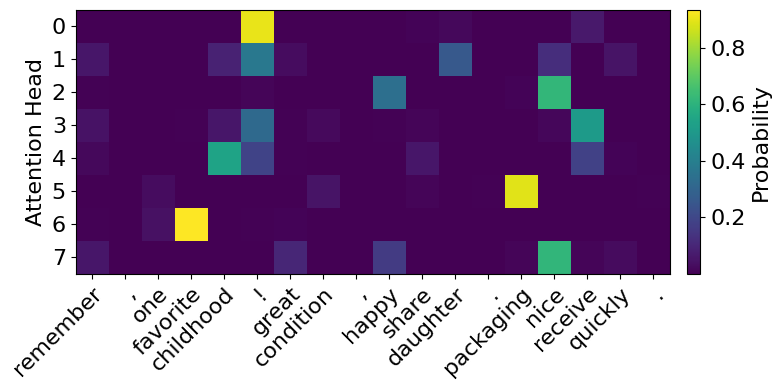

In [27]:
s = 'Just as I remembered it, one of my favorites from childhood! Great condition, very happy to have this to share with my daughter. Packaging was so nice and was received quickly.'
pred, tokens, attn = get_label_and_weights(s)
visualize_attention(tokens, attn)

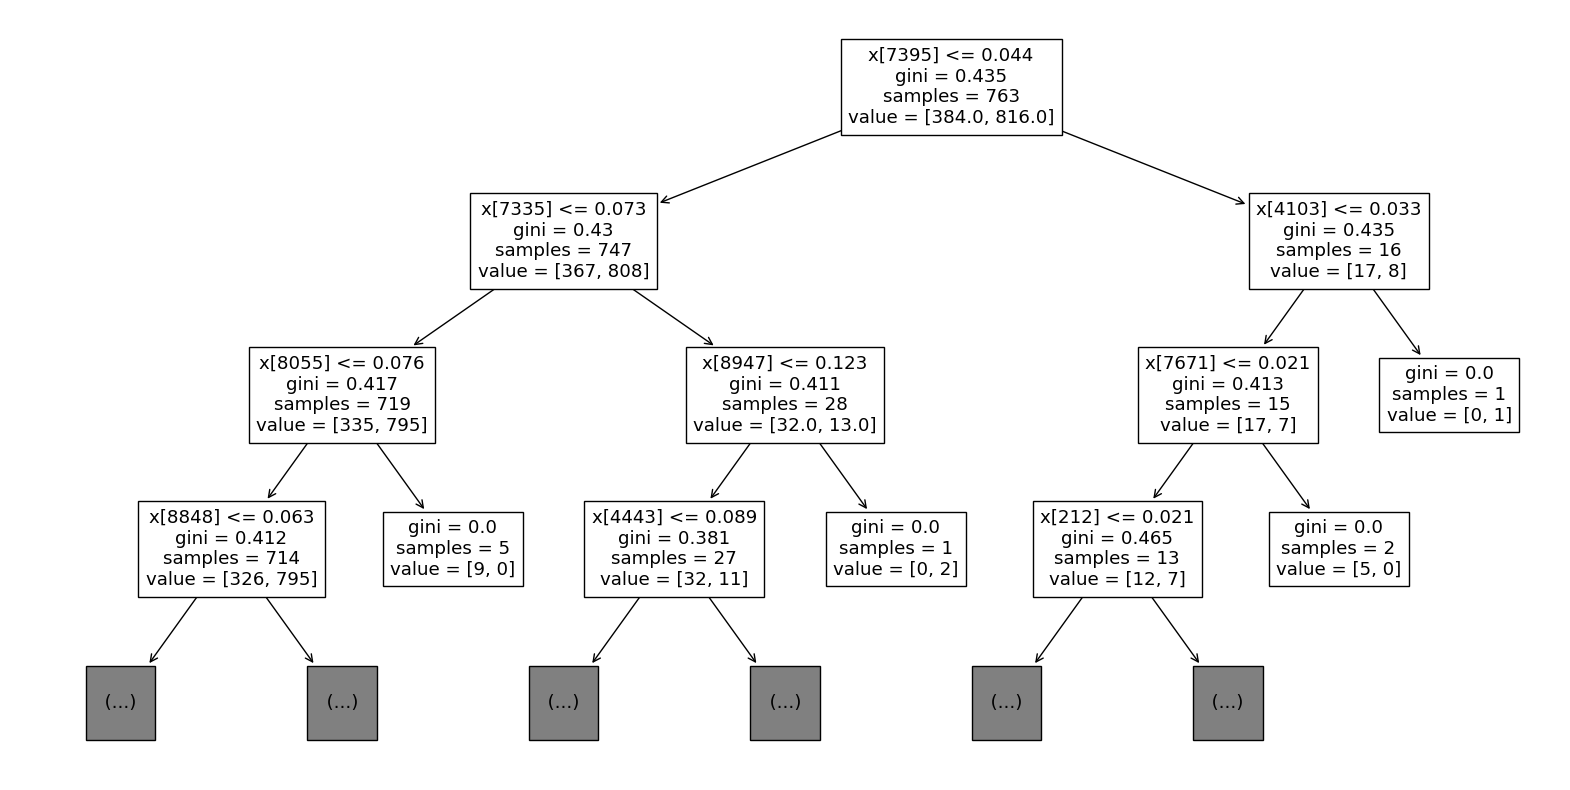

In [51]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(rf_best_model.estimators_[0], max_depth=3)
plt.show()